In [1]:
#Importing the required libraries
##########################################################################################
!pip install lightkurve
import lightkurve as lk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler
from xgboost import XGBClassifier, DMatrix, XGBRFClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
#import shap
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
from IPython.display import Markdown, display, clear_output
import ipywidgets as widgets
import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

def printmd(string):
    display(Markdown(string))

%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data loading and preprocessing

In [2]:
#Read the data from CSV file into a Pandas DataFrame
##########################################################################################

data = pd.read_pickle('/content/drive/My Drive/Exoplanet_Data/features_real_data.pkl')
data_test = pd.read_pickle('/content/drive/My Drive/Exoplanet_Data/features_real_test_data.pkl')
orig_data = pd.concat([pd.read_pickle('/content/drive/My Drive/Exoplanet_Data/train_data.pkl'), pd.read_pickle('/content/drive/My Drive/Exoplanet_Data/test_data.pkl')], ignore_index=True)
data['planet'] = np.where(data.label == 'PC', 1, 0)
data_test['planet'] = np.where(data_test.label == 'PC', 1, 0)
print(data.shape)
data.head()

(12589, 752)


variable,Data__abs_energy,Data__absolute_sum_of_changes,"Data__agg_autocorrelation__f_agg_""mean""__maxlag_40","Data__agg_autocorrelation__f_agg_""median""__maxlag_40","Data__agg_autocorrelation__f_agg_""var""__maxlag_40","Data__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","Data__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","Data__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","Data__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","Data__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""","Data__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""rvalue""","Data__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""slope""","Data__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""stderr""","Data__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""intercept""","Data__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""rvalue""","Data__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""slope""","Data__agg_linear_trend__f_agg_""max""__chunk_len_5__attr_""stderr""","Data__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""intercept""","Data__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""rvalue""","Data__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""slope""","Data__agg_linear_trend__f_agg_""mean""__chunk_len_10__attr_""stderr""","Data__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""intercept""","Data__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""rvalue""","Data__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""slope""","Data__agg_linear_trend__f_agg_""mean""__chunk_len_50__attr_""stderr""","Data__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""intercept""","Data__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""rvalue""","Data__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""slope""","Data__agg_linear_trend__f_agg_""mean""__chunk_len_5__attr_""stderr""","Data__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""intercept""","Data__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""rvalue""","Data__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""slope""","Data__agg_linear_trend__f_agg_""min""__chunk_len_10__attr_""stderr""","Data__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""intercept""","Data__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""rvalue""","Data__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""slope""","Data__agg_linear_trend__f_agg_""min""__chunk_len_50__attr_""stderr""","Data__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""intercept""","Data__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""rvalue""","Data__agg_linear_trend__f_agg_""min""__chunk_len_5__attr_""slope""",...,Data__ratio_beyond_r_sigma__r_7,Data__ratio_value_number_to_time_series_length,Data__skewness,Data__spkt_welch_density__coeff_2,Data__spkt_welch_density__coeff_5,Data__spkt_welch_density__coeff_8,Data__standard_deviation,Data__sum_of_reoccurring_data_points,Data__sum_of_reoccurring_values,Data__sum_values,Data__symmetry_looking__r_0.0,Data__symmetry_looking__r_0.05,Data__symmetry_looking__r_0.1,Data__symmetry_looking__r_0.15000000000000002,Data__symmetry_looking__r_0.2,Data__symmetry_looking__r_0.25,Data__symmetry_looking__r_0.30000000000000004,Data__symmetry_looking__r_0.35000000000000003,Data__symmetry_looking__r_0.4,Data__symmetry_looking__r_0.45,Data__symmetry_looking__r_0.5,Data__symmetry_looking__r_0.55,Data__symmetry_looking__r_0.6000000000000001,Data__symmetry_looking__r_0.65,Data__symmetry_looking__r_0.7000000000000001,Data__symmetry_looking__r_0.75,Data__symmetry_looking__r_0.8,Data__symmetry_looking__r_0.8500000000000001,Data__symmetry_looking__r_0.9,Data__symmetry_looking__r_0.9500000000000001,Data__time_reversal_asymmetry_statistic__lag_1,Data__time_reversal_asymmetry_statistic__lag_2,Data__time_reversal_asymmetry_statistic__lag_3,Data__value_count__value_-1,Data__value_count__value_0,Data__value_count__value_1,Data__variance,Data__varia

In [0]:
data = pd.concat([data, data_test], ignore_index=True)

In [0]:
Planets = data.planet
IDs = data.index
df_final = data.drop(['planet', 'label'], axis=1)
columns = df_final.columns
df_final = pd.DataFrame(RobustScaler().fit_transform(df_final)) ## TODO: Save the Scaler!!
df_final.columns = columns
df_final['Planet'] = Planets #.reset_index(drop=True)
df_final.index = IDs
df_final = df_final.loc[:, (df_final != df_final.iloc[0]).any()]

In [0]:
seed = 12345
df_final = df_final.loc[:, (df_final != df_final.iloc[0]).any()]
df_final = df_final.sample(frac=1, random_state=seed)
y1 = df_final.Planet

### Model Training

In [0]:
# Splitting our data into test and training set
##################################################################################################
X1_train, X1_test, y1_train, y1_test = model_selection.train_test_split(df_final.iloc[:,:-1], y1, test_size=0.25, random_state=seed)

In [8]:
xgbc1 = XGBClassifier(objective = 'binary:logistic', n_estimators= 1000, scale_pos_weight=3.37, max_depth= 4, subsample= 0.8, colsample_bytree= 0.5, gamma= 1)
xgbc1.fit(X1_train, y1_train)
pred1 = xgbc1.predict(X1_test)
y1_test_prob = xgbc1.predict_proba(X1_test)
score1 = [accuracy_score(y1_test, pred1), roc_auc_score(y1_test, y1_test_prob[:,1])]
report1 = classification_report(y1_test, pred1)

print(score1, '\n', report1)

[0.9395171537484117, 0.9786341736694678] 
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      3060
           1       0.82      0.93      0.87       875

    accuracy                           0.94      3935
   macro avg       0.90      0.94      0.92      3935
weighted avg       0.94      0.94      0.94      3935



In [0]:
conf_matrix = confusion_matrix(y_true, y_pred2)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
Labels = ["Benign","Fraud"]
plt.figure(figsize=(12.5, 10))
sns.set(font_scale=1.6)
ax = sns.heatmap(conf_matrix, xticklabels=Labels, yticklabels=Labels, annot=True, annot_kws={"size": 20}, fmt=".2f", cmap="Blues");
# for t in ax.texts: t.set_text(str(round(int(t.get_text())*100,2))+'%')
plt.title("Confusion Matrix")
plt.ylabel('Predicted class')
plt.xlabel('True class')
plt.show()

## LGBM Model

In [24]:
y = df_final.Planet
X = df_final.iloc[:,:-1].values
skf = StratifiedKFold(n_splits=5, shuffle = True)
skf.get_n_splits(X, y)

5

In [25]:
pp2 = {'num_iterations': 1000, 'num_leaves': 60, 'max_depth': 4, 'bagging_freq': 3, 'feature_fraction': '0.700', 'bagging_fraction': '0.800', 'objective': 'binary', 'metric': 'binary_logloss', 'scale_pos_weight': 3.37, 'seed': 12345, 'verbose': -1}

y_pred = []
y_true = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    d_train = lgb.Dataset(X_train, label=y_train)
    d_test = lgb.Dataset(X_test, label=y_test)
    clf = lgb.train(pp2, d_train)
    y_pred.extend(clf.predict(X_test))
    y_true.extend(y_test)

y_pred = np.array(y_pred) >= 0.5
target = roc_auc_score(y_true, y_pred)
print("AUC:", target)
print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


AUC: 0.4967531332106598
0.7113808222659973
              precision    recall  f1-score   support

           0       0.77      0.89      0.83     12137
           1       0.22      0.10      0.14      3600

    accuracy                           0.71     15737
   macro avg       0.49      0.50      0.48     15737
weighted avg       0.64      0.71      0.67     15737



In [0]:
df_pred = pd.DataFrame(index=df_final.index, columns=['idx', 'pred'])
df_pred.loc[:, 'idx'] = df_final.index
df_pred.loc[:, 'pred'] = xgbc1.predict_proba(df_final.drop(columns=['Planet']))[:,1]
df_pred = df_pred.sort_values(by='pred', ascending=False)
predicted_planets = df_pred[df_pred.pred>0.5]

In [0]:
bst1 = xgbc1.get_booster()
data_matrix = xgb.DMatrix(data=df_final.loc[predicted_planets.idx].drop(columns=['Planet']))
df_temp = pd.DataFrame(bst1.predict(data_matrix, pred_contribs=True))
df_temp = df_temp.iloc[:,:-1]
df_temp.columns = df_final.drop(columns=['Planet']).columns
df_temp.index = predicted_planets.idx
predicted_planets_shaps = pd.concat([predicted_planets.set_index('idx'), df_temp], axis=1)

predicted_planets_cases = df_final.loc[predicted_planets.index]
predicted_planets_cases = pd.concat([predicted_planets[['pred']], predicted_planets_cases], axis=1)

In [0]:
## False negatives: Sorted with prob
case_interest = predicted_planets_cases[predicted_planets_cases.Planet==0]

In [12]:
## Number of possible cases missed!
case_interest.shape

(181, 716)

### Overall Results: Confusion Matrix

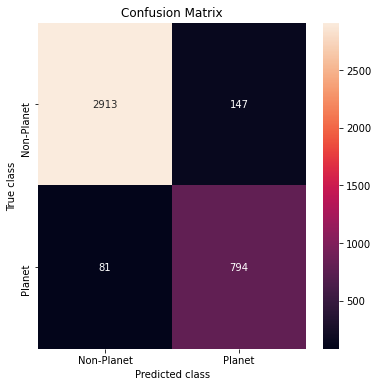

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y1_test, pred1)
Labels = ["Non-Planet","Planet"]
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=Labels, yticklabels=Labels, annot=True, fmt="d");
plt.title("Confusion Matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()